In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/0f72db9c-d635-4415-9781-68937328aed2___NREC_B.Spot 9188.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/1b8d3e98-43d9-441d-93ef-a359e6e9ddc2___NREC_B.Spot 9052.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/b6d35d21-4812-4e32-ab9a-b6ddda8cbb79___JR_B.Spot 8972.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/e4e7e5a2-5aa1-4378-833d-9142358c7c9b___JR_B.Spot 9092.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/8b50f2db-cbf2-4758-bea6-a011f0cc1497___JR_B.Spot 3235.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/729b55d7-2a99-4861-910d-3b4e2bbce13a___JR_B.Spot 9036.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/4614ed01-e120-4ae9-8f13-028fa8297873___JR_B.Spot 8985.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/b143a281-5395-4a2a-830

# ****1. Importing Libraries****

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn as nn
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from PIL import Image
from torchinfo import summary

#**2. Dataset Loading & Class Listing**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = '/kaggle/input/plant-village/PlantVillage'
image_datasets = datasets.ImageFolder(root=data_dir)
class_names = image_datasets.classes
print(f'Number of Classes: {len(class_names)}\nData set class names: \n{class_names}')

Number of Classes: 15
Data set class names: 
['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


# **3. Data Preprocessing**
**3.1 Image size inspection**

In [ ]:
from PIL import Image
import os

# Function to check image sizes
def check_image_sizes(dataset_path):
    sizes = []

    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            sample_image = os.path.join(class_dir, os.listdir(class_dir)[0])
            img = Image.open(sample_image)
            sizes.append(img.size)

    return set(sizes)

# Run the function
unique_sizes = check_image_sizes(data_dir)
print(f"Unique image sizes: {unique_sizes}")

Unique image sizes: {(256, 256)}


**3.2 Compute Mean and Standard Dievation**

In [ ]:
import numpy as np

# Function to compute mean and std of pixel values
def compute_image_statistics(dataset_path):
    means, stds = [], []

    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            sample_image = os.path.join(class_dir, os.listdir(class_dir)[0])
            img = Image.open(sample_image).convert("RGB")  # Convert to RGB
            img_array = np.array(img) / 255.0  # Normalize to [0,1]

            means.append(np.mean(img_array, axis=(0,1)))  # Mean per channel
            stds.append(np.std(img_array, axis=(0,1)))    # Std per channel

    return np.mean(means, axis=0), np.mean(stds, axis=0)

# Compute mean and std for RGB channels
mean_rgb, std_rgb = compute_image_statistics(data_dir)
print(f"Mean Pixel Values (RGB): {mean_rgb}")
print(f"Standard Deviation (RGB): {std_rgb}")

Mean Pixel Values (RGB): [0.43884681 0.45918082 0.41010109]
Standard Deviation (RGB): [0.17918875 0.15062725 0.19493578]


**3.3 Define transforms with augmentation (for training) and without (for val/test)**

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Define normalization values from EDA
MEAN = [0.43884681 ,0.45918082, 0.41010109]
STD = [0.17918875 ,0.15062725, 0.19493578]

# Define Data Transformations for Training (with Augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Define Data Transformations for Validation & Test (No Augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

**3.4 Apply ImageFolder and random_split to create train/val/test**

In [ ]:
from torch.utils.data import random_split

# Load dataset using ImageFolder
full_dataset = ImageFolder(root=data_dir, transform=train_transforms)

# Define dataset split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Compute dataset sizes
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply different transformations for validation & test sets
val_dataset.dataset.transform = val_transforms
test_dataset.dataset.transform = val_transforms  # Test set should NOT have data augmentation

# Create DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train Dataset: {len(train_dataset)} images")
print(f"Validation Dataset: {len(val_dataset)} images")
print(f"Test Dataset: {len(test_dataset)} images")


Train Dataset: 16510 images
Validation Dataset: 2063 images
Test Dataset: 2065 images


# **4. Hyperparameter Tuning**

In [ ]:
#hyperparameters
n_classes = 15
# n_epochs = 15
# batch_size = 64
learning_rate = 0.0001

# **5. Model selection and Architecture**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Define CNN Architecture
class DiseaseCNN(nn.Module):
    def __init__(self, num_classes=n_classes):
        super(DiseaseCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Conv Layer 1
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Pooling Layer

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Conv Layer 2
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Conv Layer 3
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),  # Fully Connected Layer 1
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),  # Fully Connected Layer 2
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, num_classes)  # Output Layer
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize Model
model = DiseaseCNN(num_classes=n_classes)
print(model)

DiseaseCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=512, bias=True)
    (2): ReLU()
    (3): D

In [ ]:
import torch.optim as optim

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


print("Model is ready for training!")

Model is ready for training!


# **6. Model Training**

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Initialize lists to store loss and accuracy
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

EPOCHS = 30

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation Phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/30], Train Loss: 1.0606, Train Acc: 66.83%, Val Loss: 0.4487, Val Acc: 85.70%
Epoch [2/30], Train Loss: 0.5399, Train Acc: 83.00%, Val Loss: 0.2872, Val Acc: 91.03%
Epoch [3/30], Train Loss: 0.3489, Train Acc: 88.88%, Val Loss: 0.2335, Val Acc: 93.02%
Epoch [4/30], Train Loss: 0.2571, Train Acc: 91.77%, Val Loss: 0.1969, Val Acc: 93.94%
Epoch [5/30], Train Loss: 0.1732, Train Acc: 94.39%, Val Loss: 0.1785, Val Acc: 94.72%
Epoch [6/30], Train Loss: 0.1380, Train Acc: 95.47%, Val Loss: 0.1726, Val Acc: 94.47%
Epoch [7/30], Train Loss: 0.1216, Train Acc: 96.18%, Val Loss: 0.2164, Val Acc: 94.57%
Epoch [8/30], Train Loss: 0.0916, Train Acc: 97.05%, Val Loss: 0.1932, Val Acc: 94.43%
Epoch [9/30], Train Loss: 0.0784, Train Acc: 97.42%, Val Loss: 0.2306, Val Acc: 94.23%
Epoch [10/30], Train Loss: 0.0754, Train Acc: 97.50%, Val Loss: 0.1795, Val Acc: 95.40%
Epoch [11/30], Train Loss: 0.0631, Train Acc: 98.06%, Val Loss: 0.1651, Val Acc: 95.54%
Epoch [12/30], Train Loss: 0.0529, Train 

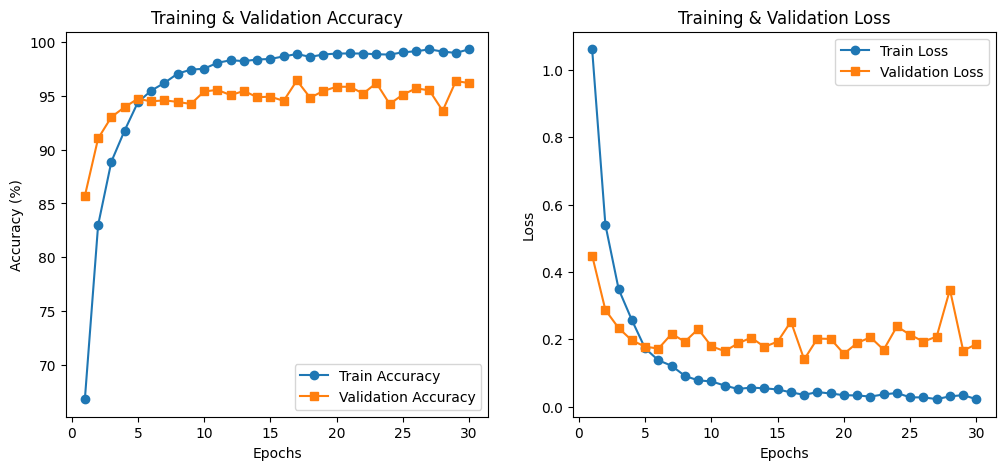

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set dark theme for better visibility
# sns.set(style="darkgrid")
# plt.style.use("dark_background")

# Create figure
plt.figure(figsize=(12, 5))

# Plot Accuracy Graph
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_accuracies, label="Train Accuracy", marker="o")
plt.plot(range(1, EPOCHS+1), val_accuracies, label="Validation Accuracy", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()

# Plot Loss Graph
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, EPOCHS+1), val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Show the plots
plt.show()

# **7. Evaluation**

In [ ]:
model.eval()  # Set model to evaluation mode
correct, total = 0, 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

val_acc = 100 * correct / total
print(f"Validation Accuracy: {val_acc:.2f}%")

Validation Accuracy: 96.17%


In [ ]:
#save the model
torch.save(model.state_dict(), './plant_disease_cnn_model_with_epoch30_.pth')

Validation Accuracy : 0.9617
Validation Precision: 0.9621
Validation Recall   : 0.9617
Validation F1-score : 0.9613

Classification Report:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.97      0.93      0.95       106
                     Pepper__bell___healthy       0.99      0.98      0.98       168
                      Potato___Early_blight       0.96      0.99      0.98       122
                       Potato___Late_blight       0.94      0.98      0.96        94
                           Potato___healthy       0.85      0.79      0.81        14
                      Tomato_Bacterial_spot       0.98      0.98      0.98       213
                        Tomato_Early_blight       0.96      0.81      0.88        99
                         Tomato_Late_blight       0.93      0.94      0.94       182
                           Tomato_Leaf_Mold       0.99      0.92      0.96       105
        

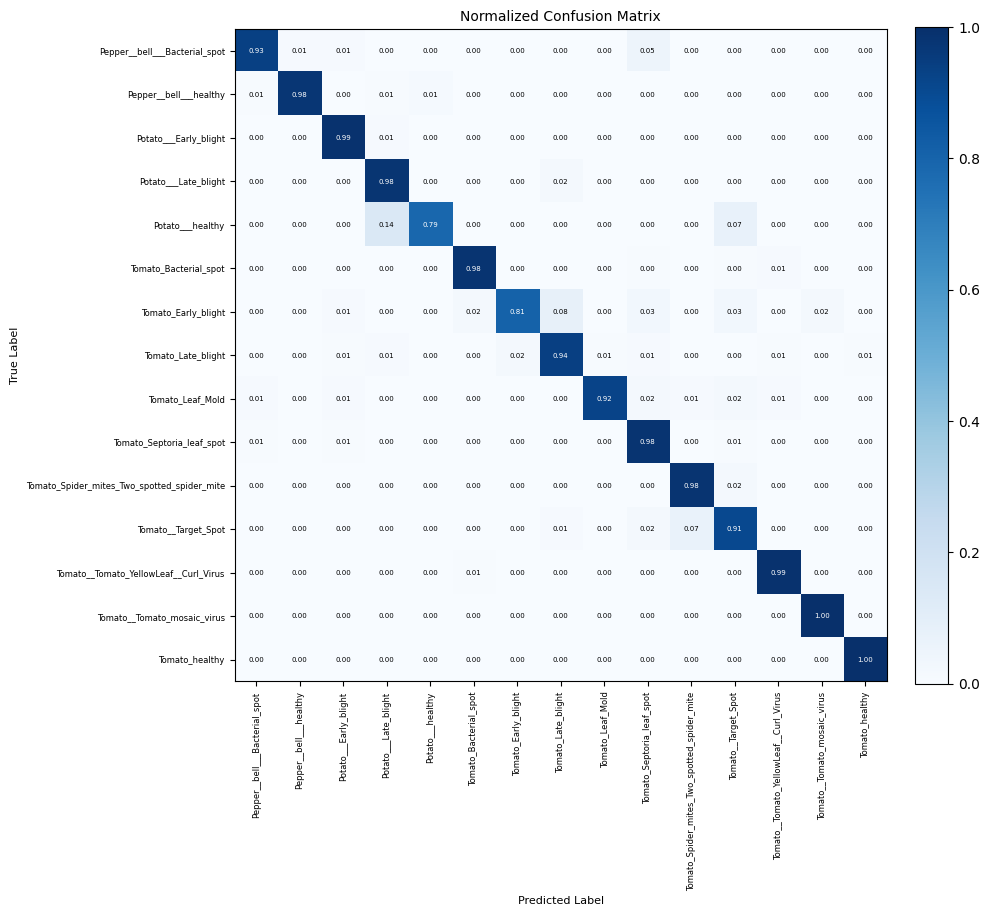

In [ ]:
import torch
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import numpy as np
import itertools

# 1. Collect predictions and true labels
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 2. Compute metrics
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
rec  = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1   = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"Validation Accuracy : {acc:.4f}")
print(f"Validation Precision: {prec:.4f}")
print(f"Validation Recall   : {rec:.4f}")
print(f"Validation F1-score : {f1:.4f}\n")

# Detailed per-class report
print("Classification Report:\n")
print(classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    zero_division=0
))

# 3. Plot confusion matrix

# 1. Compute raw confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# 2. Normalize over true labels (rows)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# 3. Plot
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# 4. Tick labels
num_classes = len(class_names)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(class_names, rotation=90, fontsize=6, ha="center")
ax.set_yticklabels(class_names, fontsize=6)

# 5. Annotate cells with two-decimal values
thresh = cm_norm.max() / 2.0
for i in range(num_classes):
    for j in range(num_classes):
        val = cm_norm[i, j]
        ax.text(
            j, i, f"{val:.2f}",
            ha="center", va="center",
            fontsize=5,
            color="white" if val > thresh else "black"
        )

ax.set_ylabel('True Label', fontsize=8)
ax.set_xlabel('Predicted Label', fontsize=8)
plt.title("Normalized Confusion Matrix", fontsize=10)
plt.tight_layout()
plt.show()

1/5  True: 5   Predicted: 5


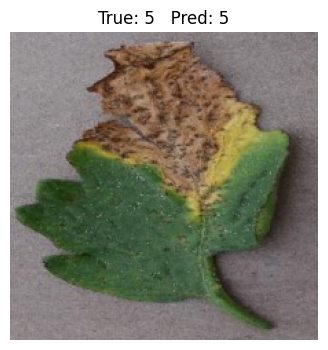

2/5  True: 12   Predicted: 12


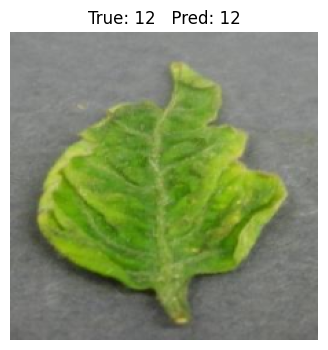

3/5  True: 9   Predicted: 9


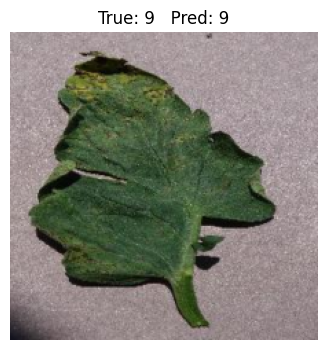

4/5  True: 9   Predicted: 9


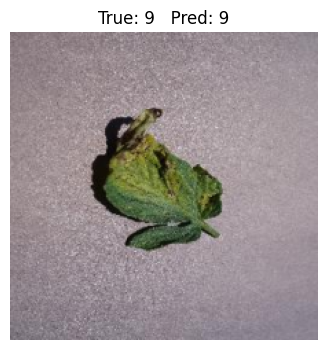

5/5  True: 12   Predicted: 12


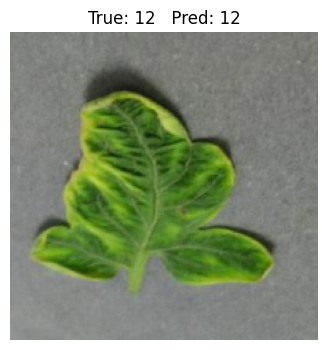

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. Define the exact MEAN and STD
mean = torch.tensor([0.4388, 0.4591, 0.4101])
std = torch.tensor([0.1791, 0.1506, 0.1949])

# 2. Define the function to reverse the normalization
def reverse_normalize(tensor, mean, std):
    """Reverses the normalization on a tensor image (C x H x W)"""
    # Clone the tensor to avoid modifying the original
    denorm_tensor = tensor.clone()

    # Reshape mean and std for broadcasting: [C] -> [C, 1, 1]
    mean = mean.view(-1, 1, 1)
    std = std.view(-1, 1, 1)

    # Perform the denormalization: (tensor * std) + mean
    denorm_tensor.mul_(std).add_(mean)

    # Clip values to the valid [0, 1] range for images
    denorm_tensor = torch.clamp(denorm_tensor, 0, 1)

    return denorm_tensor

model.eval()
num_images = 5
dataset = val_loader.dataset

for i in range(num_images):
    # Pull the i-th image & label
    img, true_label = dataset[i]

    # Prepare for model: add batch dim & move to device
    x = img.unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        out = model(x)
    _, pred = torch.max(out, 1)
    pred_label = pred.item()

    print(f"{i+1}/{num_images}  True: {true_label}   Predicted: {pred_label}")

    # 7) Denormalize using the new function and convert for plotting
    img_denorm = reverse_normalize(img.cpu(), mean, std)
    img_np = img_denorm.numpy().transpose(1, 2, 0)

    # 8) Display
    plt.figure(figsize=(4, 4))
    plt.imshow(img_np)
    plt.title(f"True: {true_label}   Pred: {pred_label}")
    plt.axis("off")
    plt.show()

Calculating accuracy over the entire test set...

--- Evaluation Complete ---
Total Test Samples: 2065
Total Correct Predictions: 1976
Total Wrong Predictions: 89
Test Set Accuracy: 95.69%

Displaying a few random sample predictions...


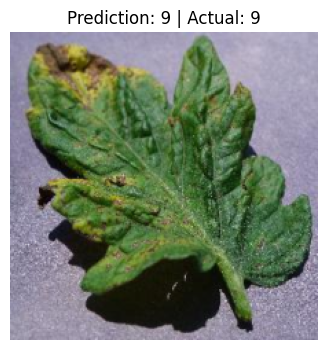

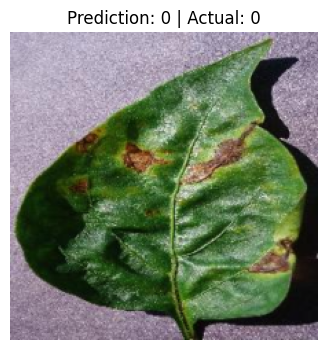

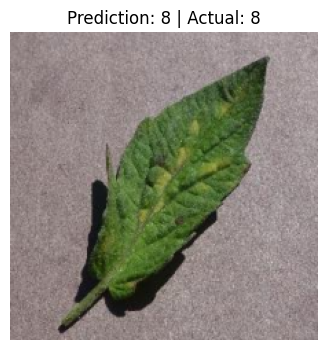

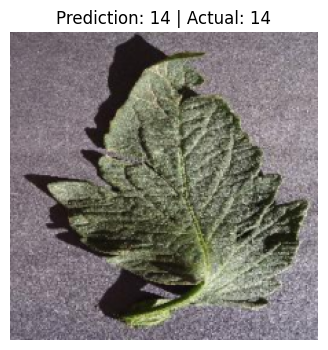

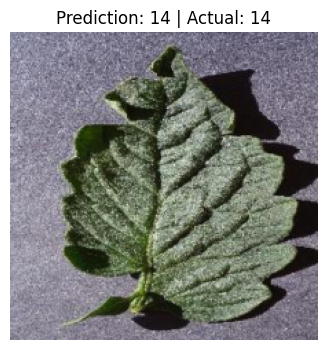

In [ ]:
# Part 1: Calculate Accuracy Over the ENTIRE Test Set
model.eval()  # Set the model to evaluation mode
correct_count = 0
total_samples = 0

print("Calculating accuracy over the entire test set...")

# Disable gradient calculations for faster inference
with torch.no_grad():
    # Process the data in batches, the way the DataLoader provides it
    for images, labels in test_loader:
        # Move the batch of images and labels to the active device (e.g., GPU)
        images = images.to(device)
        labels = labels.to(device)

        # Get model predictions for the entire batch
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        # Sum up the correct predictions in this batch
        correct_count += (predictions == labels).sum().item()

        # Count the total number of samples processed
        total_samples += labels.size(0)

# Calculate and print the final results
accuracy = (correct_count / total_samples) * 100
wrong_count = total_samples - correct_count

print(f'\n--- Evaluation Complete ---')
print(f'Total Test Samples: {total_samples}')
print(f'Total Correct Predictions: {correct_count}')
print(f'Total Wrong Predictions: {wrong_count}')
print(f'Test Set Accuracy: {accuracy:.2f}%')

# Part 2: Visualize a Few Random Predictions
print("\nDisplaying a few random sample predictions...")
test_dataset = test_loader.dataset # Get the underlying dataset object
num_to_show = 5

for i in range(num_to_show):
    # 1. Get a random image directly from the dataset
    random_index = random.randint(0, len(test_dataset) - 1)
    image, label = test_dataset[random_index]

    # 2. Prepare the single image for the model
    # Add a batch dimension [C, H, W] -> [1, C, H, W] and move to device
    image_for_model = image.unsqueeze(0).to(device)

    # 3. Get the prediction
    with torch.no_grad():
        output = model(image_for_model)
    _, prediction = torch.max(output, 1)

    # 4. Denormalize the image for plotting
    img_denorm = reverse_normalize(image.cpu(), mean, std)

    # Convert from PyTorch tensor to NumPy array and fix dimensions
    img_np = img_denorm.numpy().transpose(1, 2, 0)

    # 5. Show the image and labels
    plt.figure(figsize=(4, 4))
    plt.imshow(img_np)
    plt.title(f'Prediction: {prediction.item()} | Actual: {label}')
    plt.axis('off')
    plt.show()